### News data needs to be combined with market first to map with date and target.
### All missing data are dropped once merged. Because once mapped with date and assetCode, news_df will have lots of missing data.

In [1]:
import numpy as np
import pandas as pd
import gc

from sklearn import *
import time
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

In [2]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [3]:
(market_train_df, news_train_df) = env.get_training_data()

## Functions for data processing.

In [4]:
### Process market data.
def market_process(market_train_df):
    
    market_train_df['time'] = market_train_df.time.dt.date
    market_train_df['bartrend'] = market_train_df['close'] / market_train_df['open']
    market_train_df['average'] = (market_train_df['close'] + market_train_df['open'])/2
    market_train_df['pricevolume'] = market_train_df['volume'] * market_train_df['close']
    
    # drop nans or not?
    #market_train_df.dropna(axis=0, inplace=True)
    market_train_df.drop('assetName', axis=1, inplace=True)

    # Set datatype to float32 to save space
    float_cols = {c: 'float32' for c in market_train_df.columns if c not in ['assetCode', 'time']}
    
    return market_train_df.astype(float_cols)

### process news data.
def news_process(news_train_df):
    
    news_train_df['time'] = news_train_df.time.dt.date
    news_train_df['position'] = news_train_df['firstMentionSentence'] / news_train_df['sentenceCount']
    news_train_df['coverage'] = news_train_df['sentimentWordCount'] / news_train_df['wordCount']
    droplist_for_now = ['sourceTimestamp','firstCreated','subjects','audiences','headline','assetName']
    news_train_df.drop(droplist_for_now, axis=1, inplace=True)
    
    # factorize the following three
    for col in ['headlineTag', 'provider', 'sourceId', 'marketCommentary']:
        news_train_df[col], uniques = pd.factorize(news_train_df[col])
        del uniques
    
    # Remove {} and '' from assetCodes column
    news_train_df['assetCodes'] = news_train_df['assetCodes'].apply(lambda x: x[1:-1].replace("'", ""))
    return news_train_df

## Unstack assetCodes.
def unstack_asset_codes(news_train_df):
    codes = []
    indexes = []
    for i, values in news_train_df['assetCodes'].iteritems():
        explode = values.split(", ")
        codes.extend(explode)
        repeat_index = [int(i)]*len(explode)
        indexes.extend(repeat_index)
    index_df = pd.DataFrame({'news_index': indexes, 'assetCode': codes})
    del codes, indexes
    gc.collect()
    return index_df

## Merge news on index
def merge_news_on_index(news_train_df, index_df):
    news_train_df['news_index'] = news_train_df.index.copy()

    # Merge news on unstacked assets
    news_unstack_df = index_df.merge(news_train_df, how='left', on='news_index')
    news_unstack_df.drop(['news_index', 'assetCodes'], axis=1, inplace=True)
    return news_unstack_df

## Comine multiple news reports for same assets on same day.
def group_news(news_frame):
    
    aggregations = ['mean']
    gp = news_frame.groupby(['assetCode', 'time']).agg(aggregations)
    gp.columns = pd.Index(["{}_{}".format(e[0], e[1]) for e in gp.columns.tolist()])
    gp.reset_index(inplace=True)
    # Set datatype to float32
    float_cols = {c: 'float32' for c in gp.columns if c not in ['assetCode', 'time']}
    return gp.astype(float_cols)

### Merge market and news data
def merge(market_train_df,news_agg_df):
    
    df = market_train_df.merge(news_agg_df, how='left', on=['time','assetCode'])
    # drop nans or not?
    #df.dropna(axis=0, inplace=True)
    
    del market_train_df, news_agg_df
    return df

######################################################

def data_processing(market_train_df, news_train_df):
    ## Market
    market_train_df = market_process(market_train_df)
    print("Market data shape: ", market_train_df.shape)
    
    ## News
    news_train_df = news_process(news_train_df)
    index_df = unstack_asset_codes(news_train_df)
    news_unstack_df = merge_news_on_index(news_train_df, index_df)
    del news_train_df, index_df
    news_agg_df = group_news(news_unstack_df)
    del news_unstack_df
    print('News data shape: ', news_agg_df.shape)
          
    ## Merge
    df = merge(market_train_df,news_agg_df)
    print('Merged shape: ', df.shape)
    
    df.dropna(axis=0, inplace=True)
    print('wo missing shape: ', df.shape)
    
    gc.collect()
    return df

## Data processing.
### Get df_news and df.

In [5]:
df = data_processing(market_train_df, news_train_df)

# extract useful data.
dates = df.time
num_target = df.returnsOpenNextMktres10.astype('float32')
bin_target = (df.returnsOpenNextMktres10 >= 0).astype('int8')
universe = df.universe.astype('int8')

#Slice out df_news for LR. Clean df for lgb.
def data_slice(df):
    # Drop columns that are not features
    df.drop(['returnsOpenNextMktres10', 'universe', 'assetCode', 'time'], axis=1, inplace=True)
    
    market_column = df.columns.tolist()[:14] #14
    news_column = df.columns.tolist()[14:] #29
    
    # df_news for B.
    df_news = df[news_column]
    print('df_news shape: ', df_news.shape)
    
    # df for C.
    drop_list = ['takeSequence_mean','provider_mean','firstMentionSentence_mean',
                'headlineTag_mean','marketCommentary_mean',
                'noveltyCount12H_mean','noveltyCount24H_mean','noveltyCount3D_mean','sourceId_mean',
                'noveltyCount5D_mean','noveltyCount7D_mean','urgency_mean','sentimentClass_mean']
    df.drop(drop_list, axis=1, inplace=True)
    print('df shape: ', df.shape)
    
    return df_news, df

df_news, df = data_slice(df)

Market data shape:  (4072956, 18)
News data shape:  (3839367, 31)
Merged shape:  (4072956, 47)
wo missing shape:  (1121521, 47)
df_news shape:  (1121521, 29)
df shape:  (1121521, 30)


## Split data for training.

In [6]:
# random sample split
train_index, test_index = model_selection.train_test_split(df.index.values, test_size=0.25, 
                                                           random_state = 11)

## B - Train logistic regression classifier for news only.
It will not converge even with iteraction=400.

In [7]:
def train_news_model(df_news):
    t = time.time()
    print('Fitting Up')
    clf = LogisticRegression(solver='sag', max_iter=200, n_jobs=4) # Stochastic Average Gradient: fast
    clf.fit(df_news.loc[train_index],bin_target.loc[train_index])
    print('Done')
    print(f'Done, time = {time.time() - t}')
    return clf

trainedModel_B = train_news_model(df_news)
print(trainedModel_B)

Fitting Up
Done
Done, time = 205.98247146606445
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn', n_jobs=4,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## B - LR Evaluation

In [8]:
print("LR clf accuracy : %f" % \
      accuracy_score(trainedModel_B.predict(df_news.loc[test_index]),
                     bin_target.loc[test_index]))
print("LR clf AUC : %f" % \
      roc_auc_score(bin_target.loc[test_index].values,
                    trainedModel_B.predict_proba(df_news.loc[test_index])[:, 1]))

LR clf accuracy : 0.507167
LR clf AUC : 0.502644


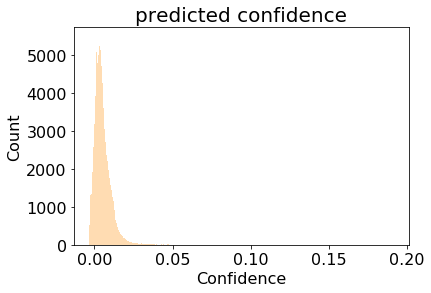

In [9]:
plt.hist(trainedModel_B.predict_proba(df_news.loc[test_index])[:, 1]*2-1, 
         bins='auto', alpha=0.3, color='darkorange')
#plt.legend(['Ground truth', 'Predicted'])
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.title("predicted confidence")
plt.show()

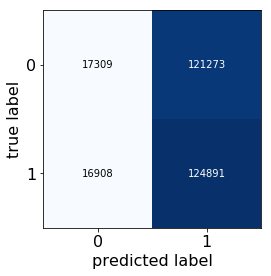

In [10]:
cfm = confusion_matrix(y_target=np.array(bin_target.loc[test_index]), 
                       y_predicted=trainedModel_B.predict(df_news.loc[test_index]).tolist())
fig, ax = plot_confusion_matrix(conf_mat=cfm)
plt.show()

## Restart the Kernel to run your code again
In order to combat cheating, you are only allowed to call `make_env` or iterate through `get_prediction_days` once per Kernel run.  However, while you're iterating on your model it's reasonable to try something out, change the model a bit, and try it again.  Unfortunately, if you try to simply re-run the code, or even refresh the browser page, you'll still be running on the same Kernel execution session you had been running before, and the `twosigmanews` module will still throw errors.  To get around this, you need to explicitly restart your Kernel execution session, which you can do by pressing the Restart button in the Kernel Editor's bottom Console tab:
![Restart button](https://i.imgur.com/hudu8jF.png)